In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

## Sketch

In [60]:
df_list = []
for f in ('GP', 'sin', 'Gaussian bump'):
    for d_observation in (10, 20, 50, 100, 200, 500, 1000):
        for method in ('PCA', 'KPCA', 'LE', 'LLE', 'TSNE', 'Isomap', 'UMAP', 'GPLVM', 'IKD'):
            try:
                df_list.append(pd.read_csv(f'outputs/{f}_{d_observation}_{method}.csv', index_col=0))
            except:
                pass
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)

Text(0, 0.5, '$R^2$')

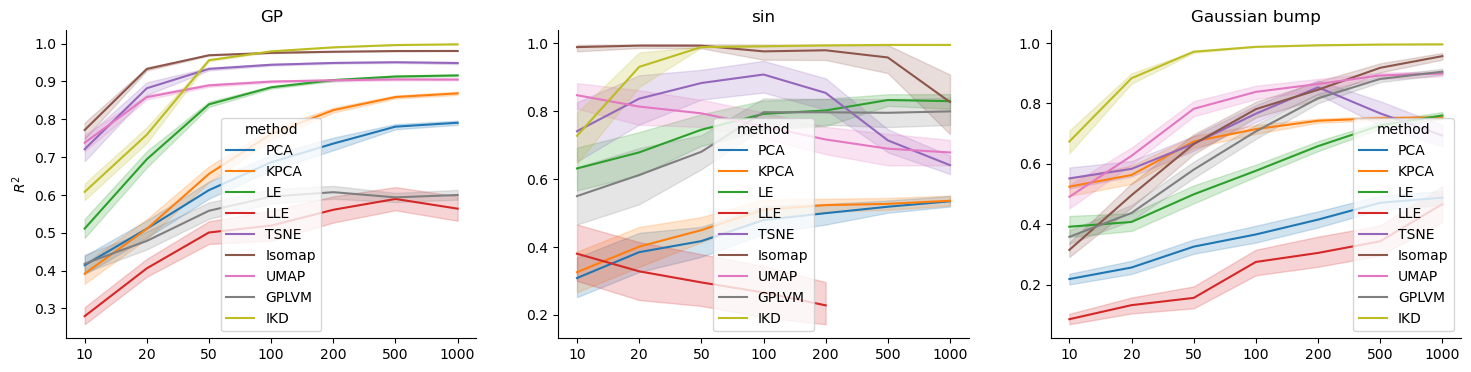

In [61]:
f_list = df.f.unique()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    ax = sns.lineplot(x='d_observation', y='$R^2$', hue='method', data=df[(df.f == f_list[i]).values], ax=axs[i])
    ax.set(xlabel=None, ylabel=None)
    ax.set_title(f_list[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[0].set_ylabel('$R^2$')

Text(0, 0.5, 'runtime')

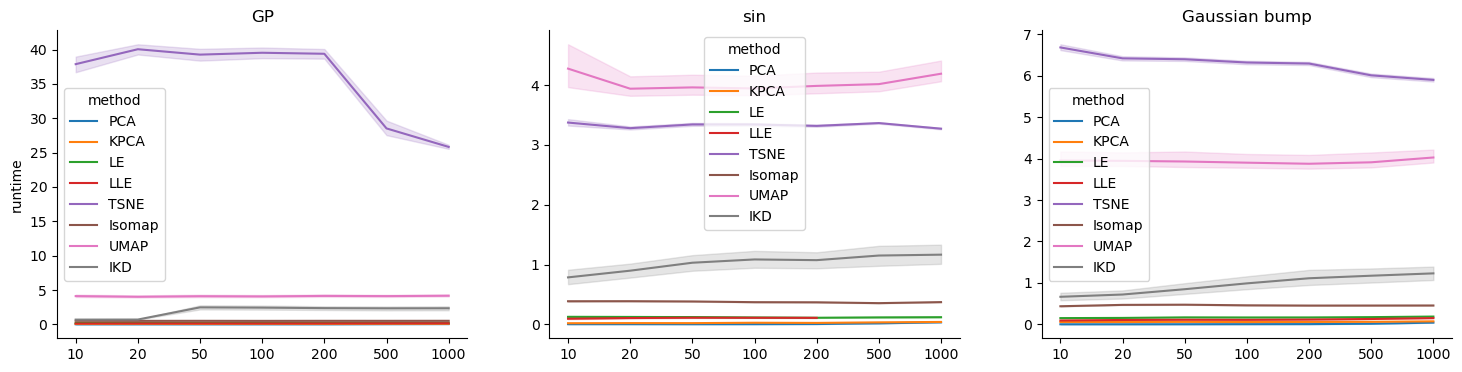

In [62]:
f_list = df.f.unique()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    ax = sns.lineplot(x='d_observation', y='runtime', hue='method', data=df[(np.bitwise_and(df.f == f_list[i], df.method != 'GPLVM')).values], ax=axs[i])
    ax.set(xlabel=None, ylabel=None)
    ax.set_title(f_list[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[0].set_ylabel('runtime')

## Whole experiment

In [8]:
df_list = []
for f in ('GP', 'sin', 'Gaussian bump'):
    for d_observation in (10, 20, 50, 100, 200, 500, 1000):
        for method in ('PCA', 'KPCA', 'LE', 'TSNE', 'Isomap', 'UMAP', 'GPLVM', 'IKD'):
            df_list.append(pd.read_csv(f'outputs/{f}_{d_observation}_{method}.csv', index_col=0))
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)

result = pd.DataFrame(index=['GP', 'sin', 'Gaussian bump'], columns=['PCA', 'KPCA', 'LE', 'Isomap', 'TSNE', 'UMAP', 'GPLVM', 'IKD', 'True'])

### GP

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 506


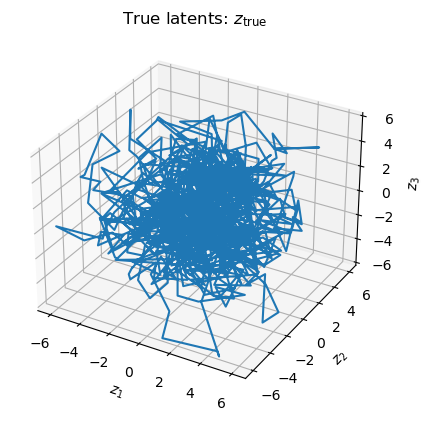

<Figure size 640x480 with 0 Axes>

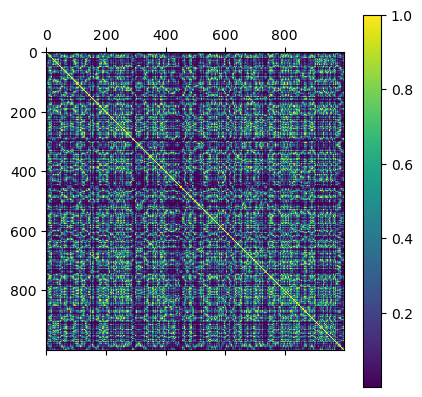

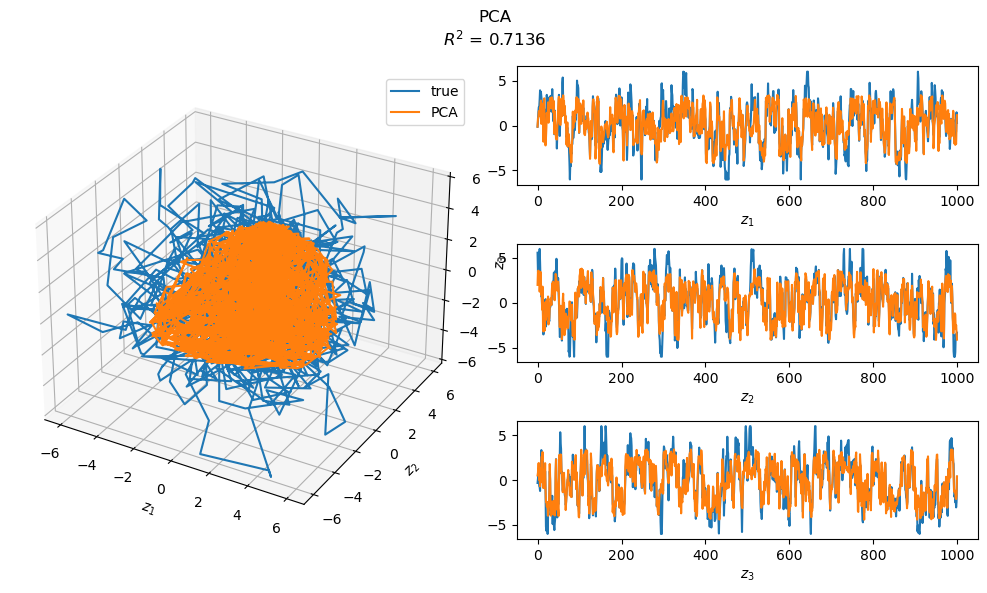

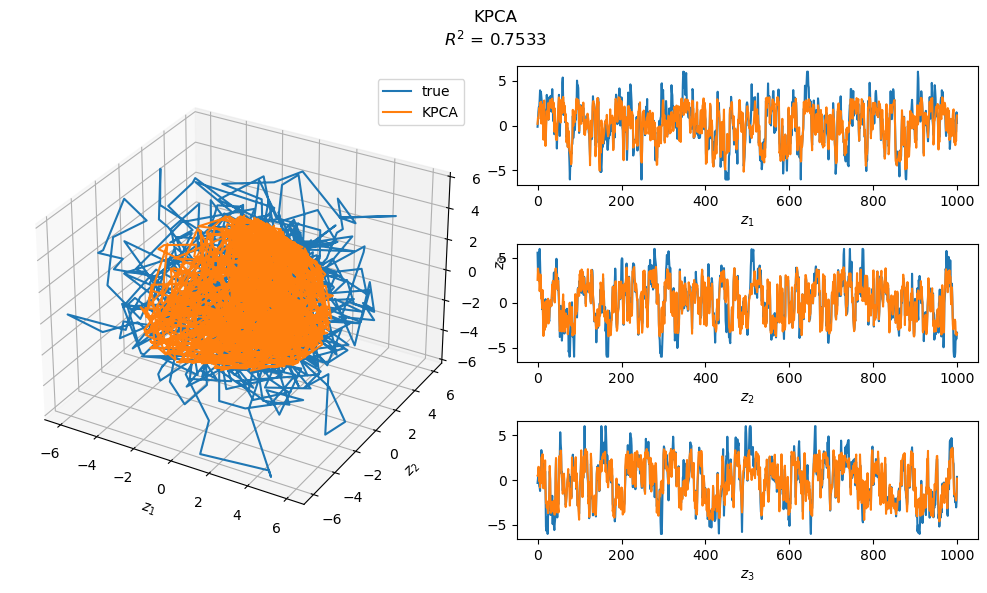

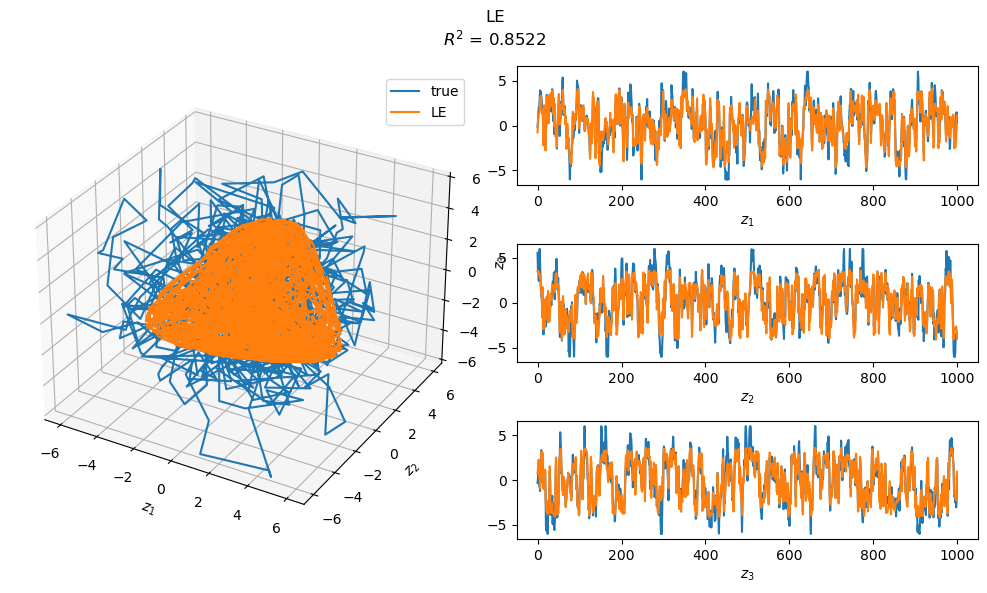

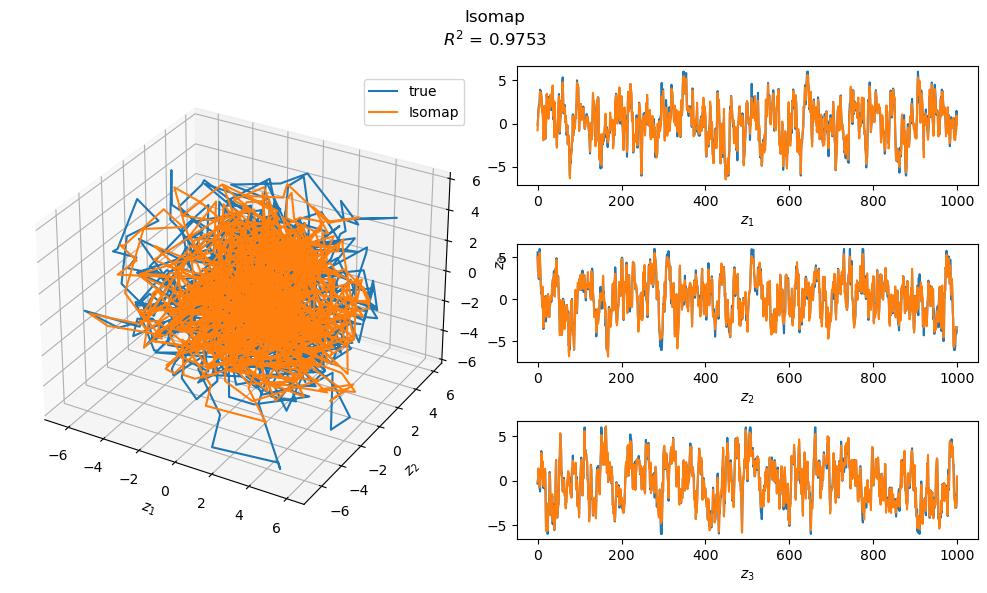

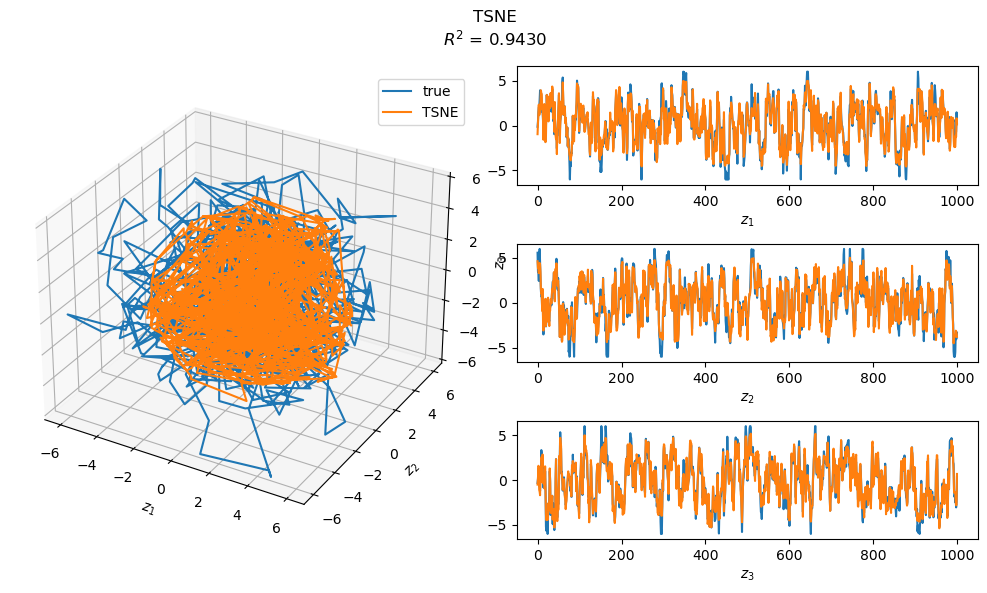

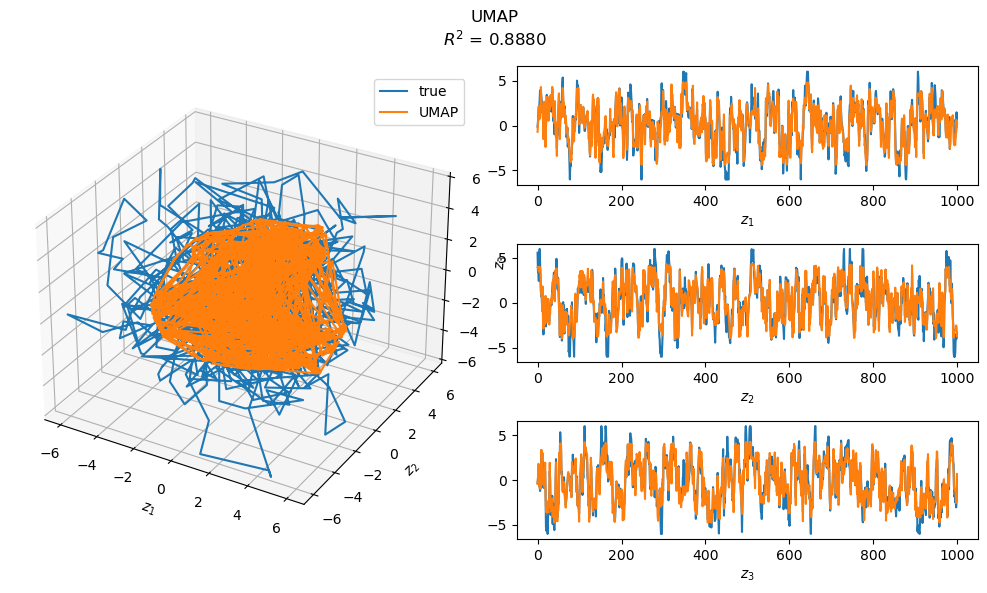

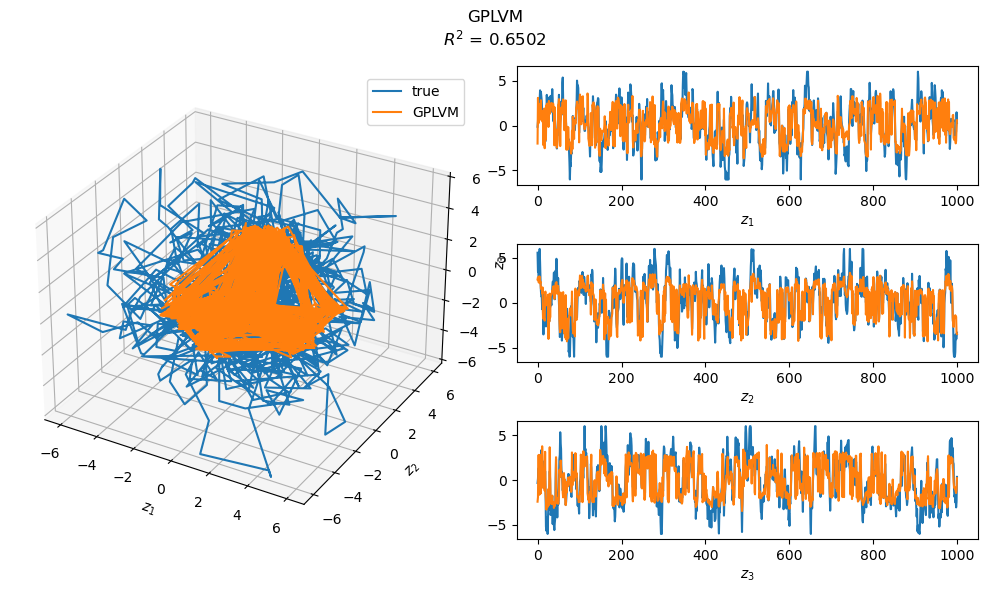

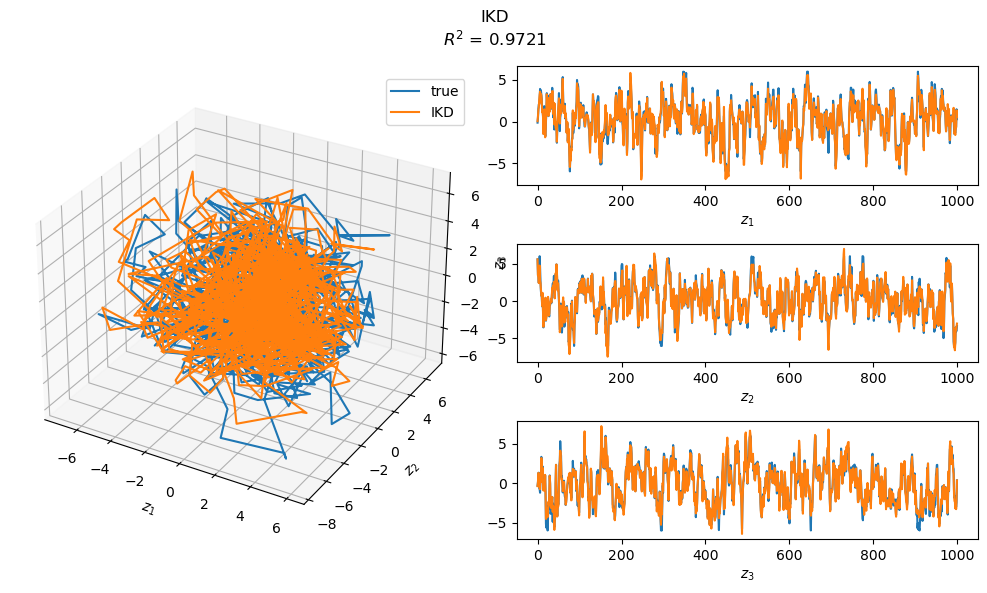

In [9]:
d_latent = 3
n_points = 1000
d_observation = 100
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
plt.title("True latents: $z_\\mathrm{true}$")

cov_true = utils.kernel_cov_generator(z_true, length_scale=3)
plt.figure()
plt.matshow(cov_true)
plt.colorbar()

x = datasets.gaussian_process_generator(cov_true, d_observation, seed=seed) + rng.normal(scale=0.05, size=(n_points, d_observation))

z_pca = PCA(n_components=d_latent).fit_transform(x) # PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kpca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kpca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
z_gplvm = m_gplvm.X.values
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), "GPLVM")

z_ikd = core.ikd_blockwise(x, d_latent, clique_th=0.6, max_n_cliques=2)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

z_pca_aligned = utils.align(z_true, z_pca)
z_kpca_aligned = utils.align(z_true, z_kpca)
z_le_aligned = utils.align(z_true, z_le)
z_isomap_aligned = utils.align(z_true, z_isomap)
z_tsne_aligned = utils.align(z_true, z_tsne)
z_umap_aligned = utils.align(z_true, z_umap)
z_gplvm_aligned = utils.align(z_true, z_gplvm)
z_ikd_aligned = utils.align(z_true, z_ikd)

result.loc['GP'] = [z_pca_aligned, z_kpca_aligned, z_le_aligned, z_isomap_aligned, z_tsne_aligned, z_umap_aligned, z_gplvm_aligned, z_ikd_aligned, z_true]

### sin

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 78


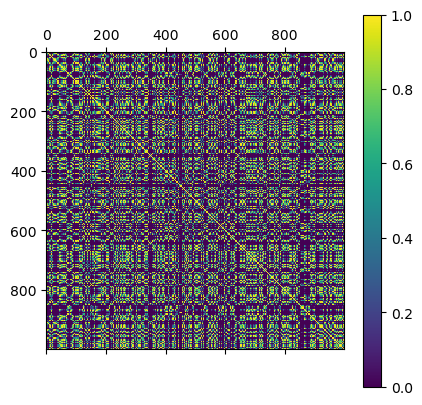

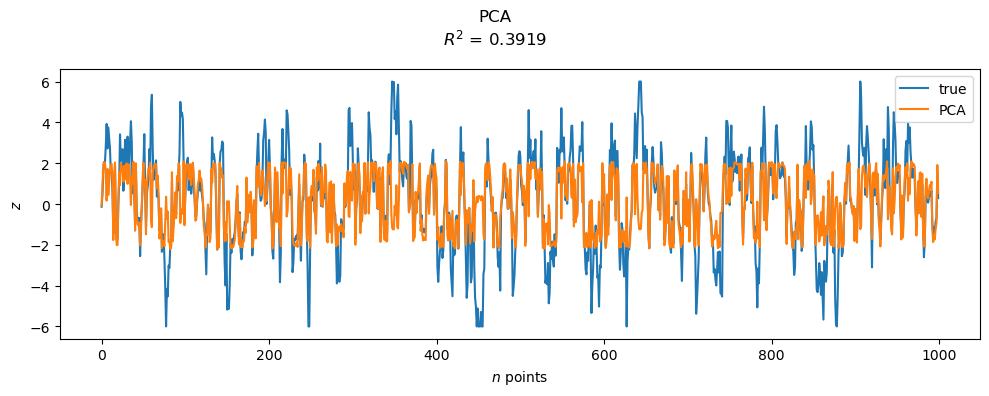

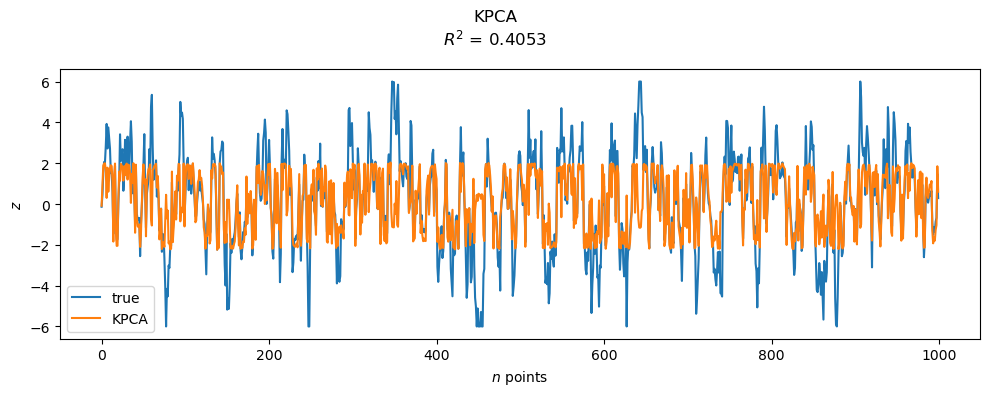

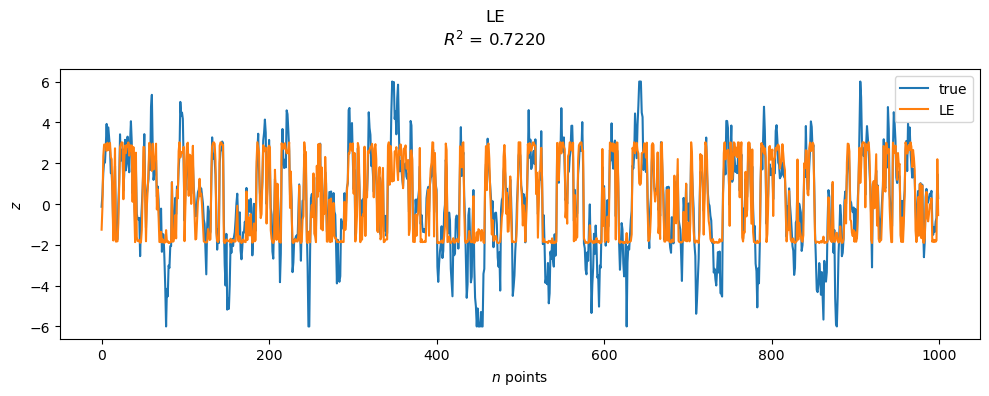

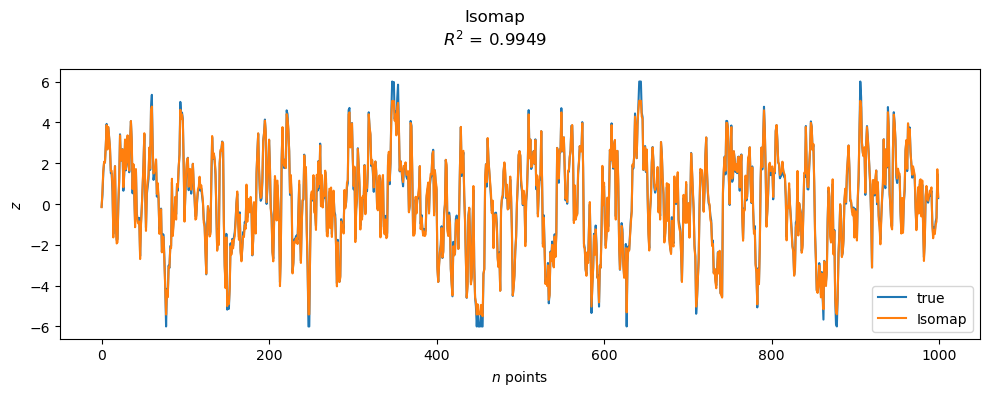

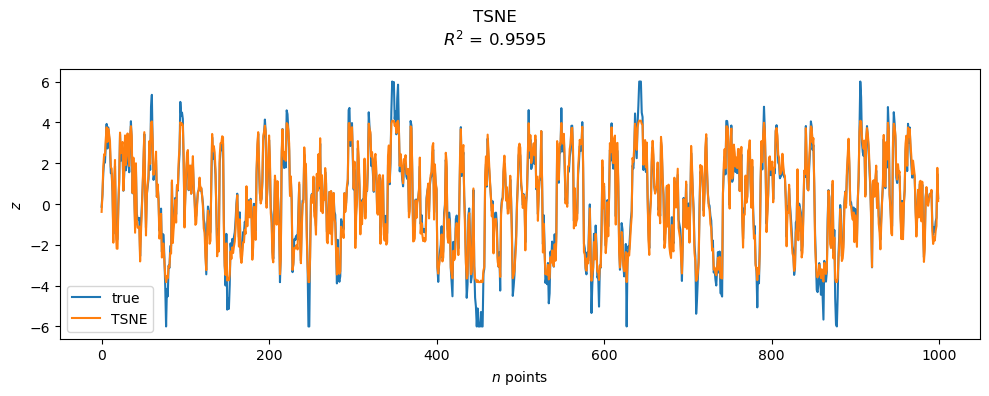

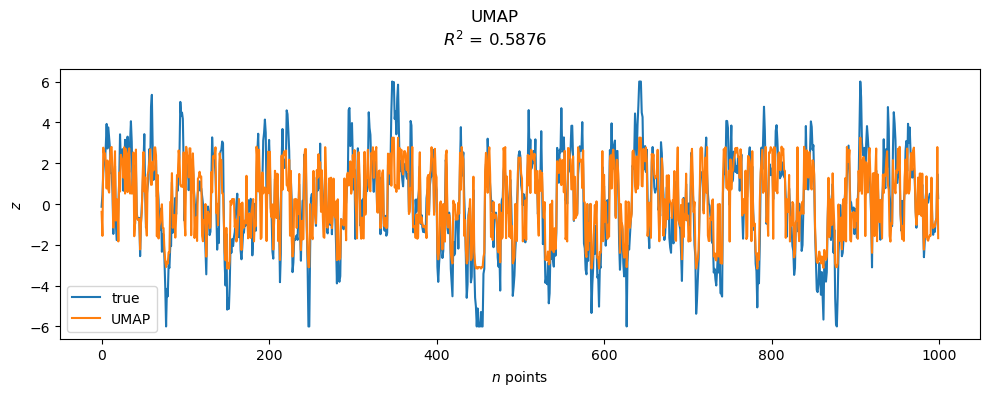

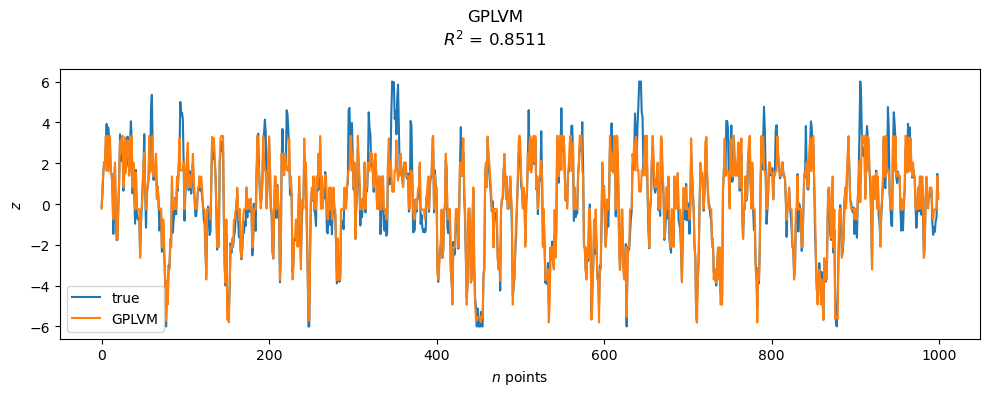

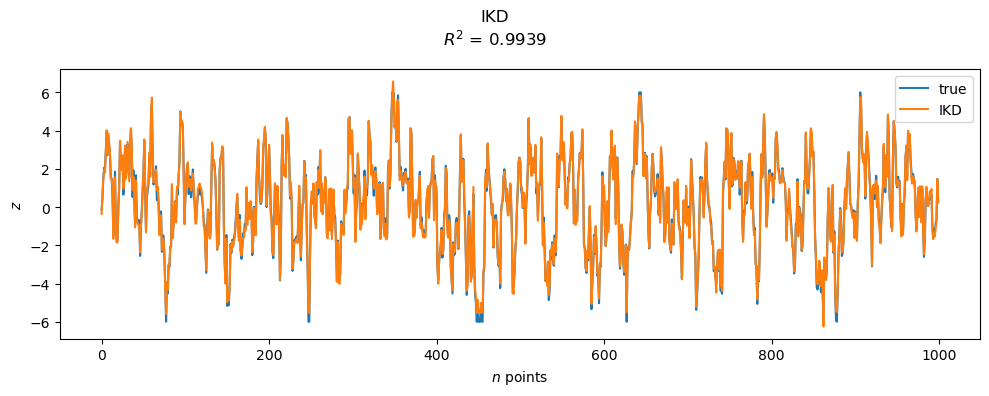

In [10]:
d_latent = 1
n_points = 1000
d_observation = 100
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
plt.matshow(utils.kernel_cov_generator(z_true))
plt.colorbar()
omega = rng.uniform(low=-1, high=1, size=(d_observation, d_latent))
phi = rng.uniform(low=-np.pi, high=np.pi, size=(1, d_observation))
x = np.sin(z_true @ omega.T + phi) + rng.normal(scale=0.1, size=(n_points, d_observation))

z_pca = PCA(n_components=d_latent).fit_transform(x)
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kpca = KernelPCA(n_components=d_latent, kernel='cosine').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kpca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
z_gplvm = m_gplvm.X.values
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), "GPLVM")

z_ikd = core.ikd_blockwise(x, d_latent, clique_th=0.6, max_n_cliques=2)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

z_pca_aligned = utils.align(z_true, z_pca)
z_kpca_aligned = utils.align(z_true, z_kpca)
z_le_aligned = utils.align(z_true, z_le)
z_isomap_aligned = utils.align(z_true, z_isomap)
z_tsne_aligned = utils.align(z_true, z_tsne)
z_umap_aligned = utils.align(z_true, z_umap)
z_gplvm_aligned = utils.align(z_true, z_gplvm)
z_ikd_aligned = utils.align(z_true, z_ikd)

result.loc['sin'] = [z_pca_aligned, z_kpca_aligned, z_le_aligned, z_isomap_aligned, z_tsne_aligned, z_umap_aligned, z_gplvm_aligned, z_ikd_aligned, z_true]

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.2, number of cliques: 126


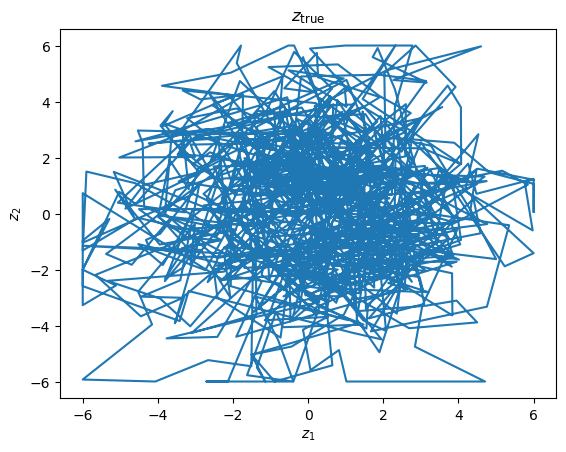

<Figure size 640x480 with 0 Axes>

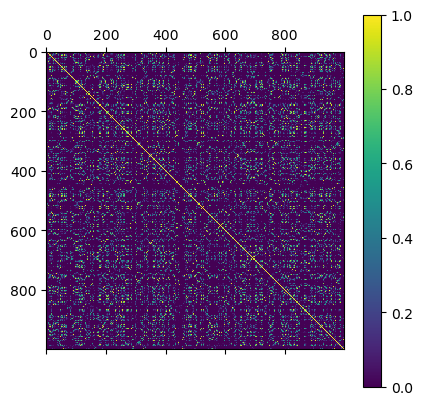

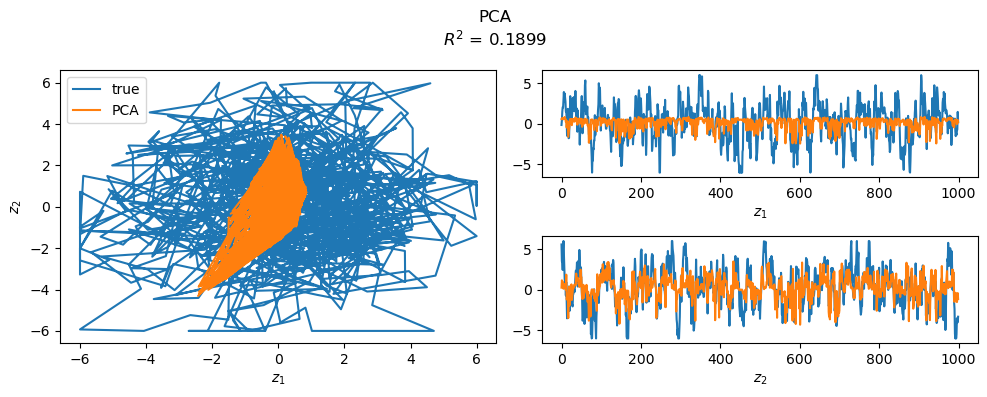

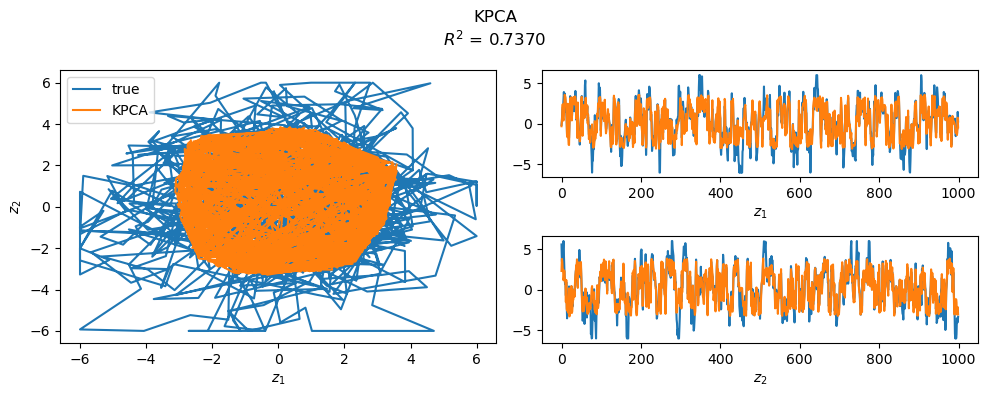

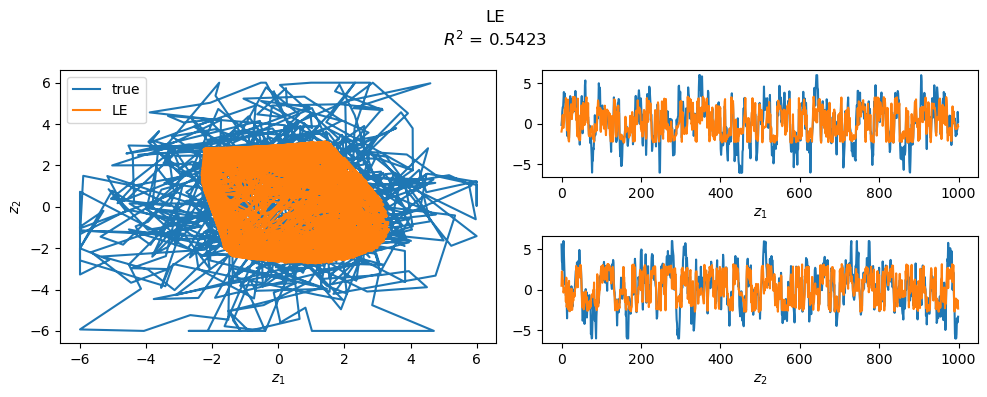

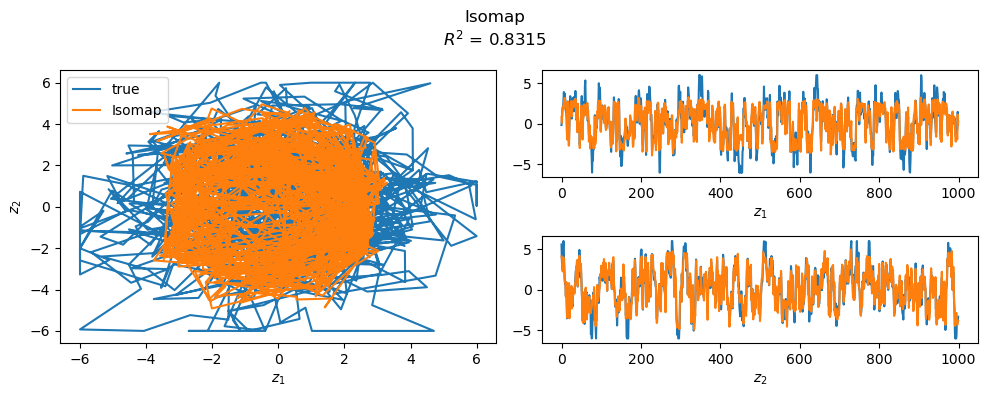

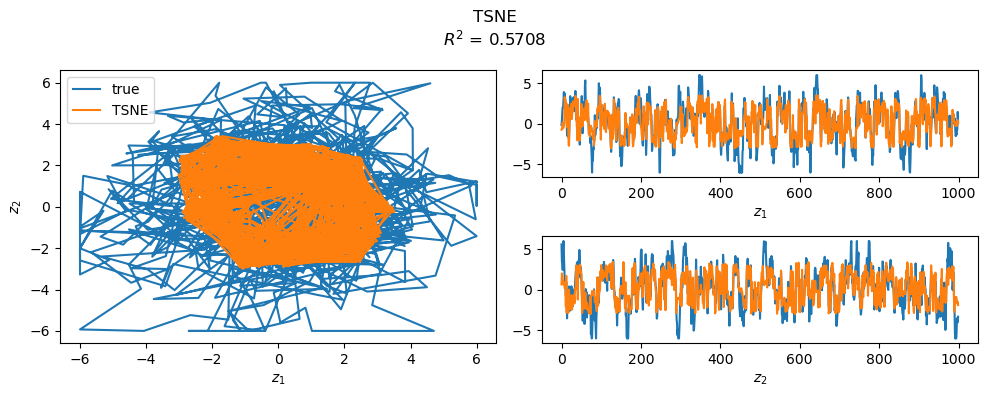

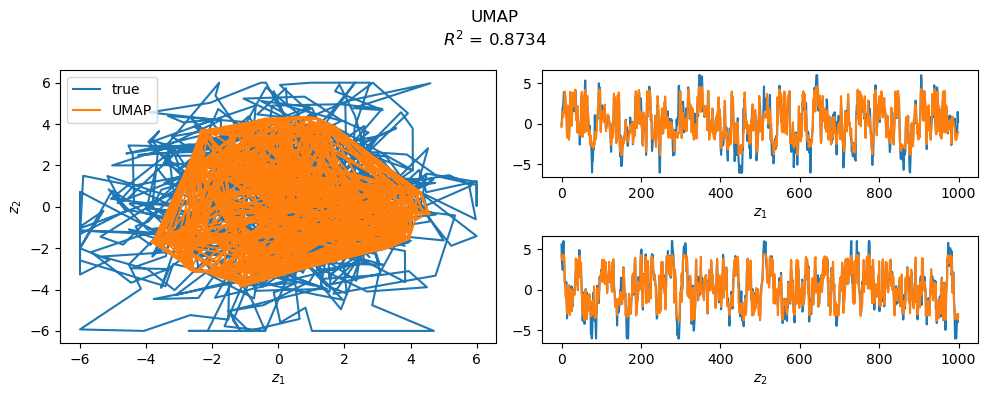

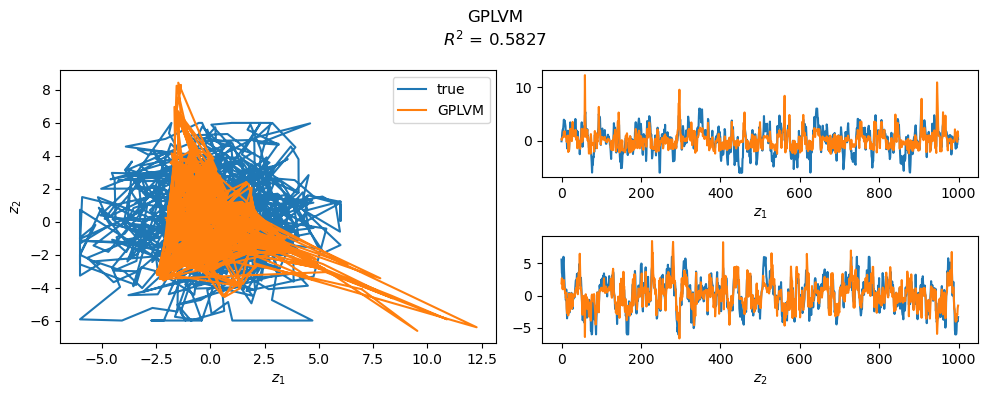

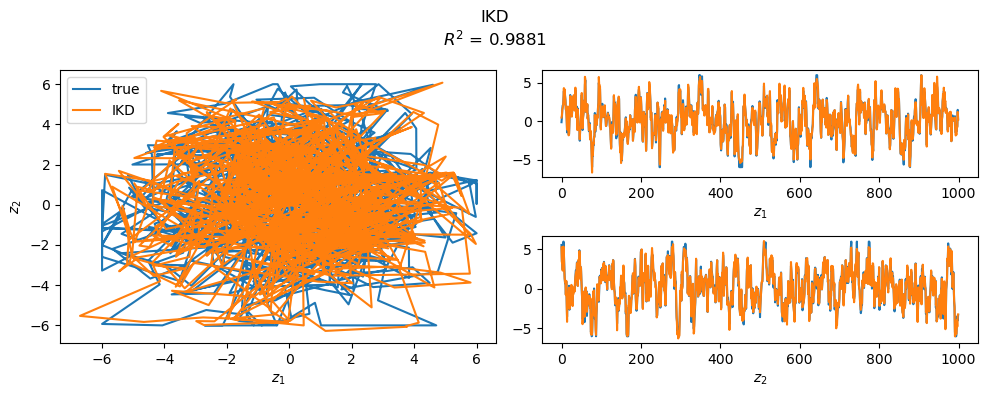

In [13]:
d_latent = 2
n_points = 1000
d_observation = 100
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
plt.plot(z_true[:, 0], z_true[:, 1])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('$z_{\\mathrm{true}}$')

cov_true = utils.kernel_cov_generator(z_true)
plt.figure()
plt.matshow(cov_true)
plt.colorbar()

x = datasets.gaussian_bump_generator(z_true, 100, d_observation, area=6, variance=20, length_scale=1, seed=seed) + rng.normal(scale=0.05, size=(n_points, d_observation))

z_pca = PCA(n_components=d_latent).fit_transform(x) # PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kpca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kpca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
z_gplvm = m_gplvm.X.values
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), "GPLVM")

z_ikd = core.ikd_blockwise(x, d_latent, clique_th=0.2, max_n_cliques=2)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

z_pca_aligned = utils.align(z_true, z_pca)
z_kpca_aligned = utils.align(z_true, z_kpca)
z_le_aligned = utils.align(z_true, z_le)
z_isomap_aligned = utils.align(z_true, z_isomap)
z_tsne_aligned = utils.align(z_true, z_tsne)
z_umap_aligned = utils.align(z_true, z_umap)
z_gplvm_aligned = utils.align(z_true, z_gplvm)
z_ikd_aligned = utils.align(z_true, z_ikd)

result.loc['Gaussian bump'] = [z_pca_aligned, z_kpca_aligned, z_le_aligned, z_isomap_aligned, z_tsne_aligned, z_umap_aligned, z_gplvm_aligned, z_ikd_aligned, z_true]

In [29]:
result.to_csv('single_trial.csv')

## Plot

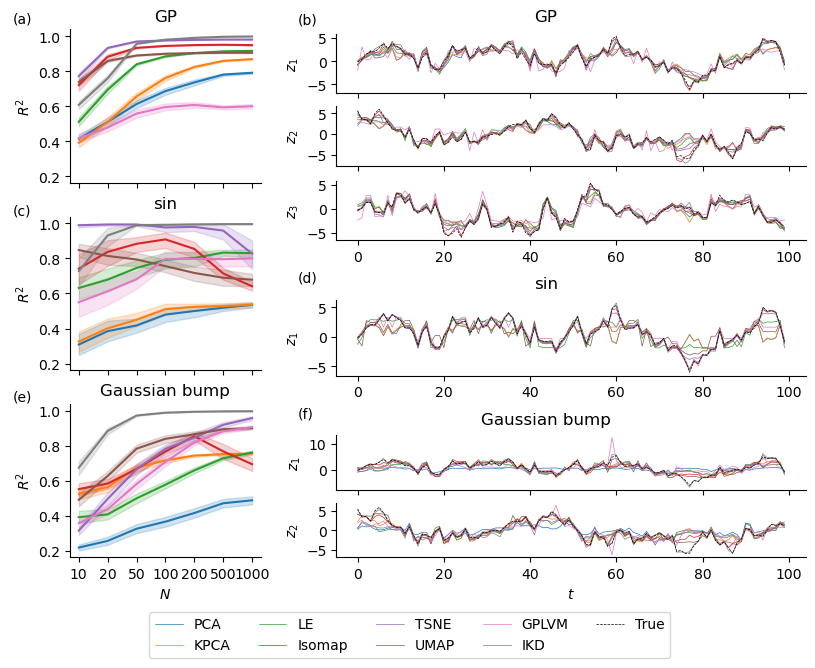

In [34]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

subfigs = fig.subfigures(1, 2, width_ratios=[1, 2])
axs = subfigs[0].subplots(3, 1, sharex=True, sharey=True)
for i in range(3):
    ax = sns.lineplot(x='d_observation', y='$R^2$', hue='method', data=df[df['f'] == ('GP', 'sin', 'Gaussian bump')[i]], ax=axs[i], palette=color_list, legend=False)
    ax.set(xlabel='$N$', ylabel='$R^2$', title=result.index[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
subfigs[0].text(0.01, 0.97, '(a)')
subfigs[0].text(0.01, 0.65, '(c)')
subfigs[0].text(0.01, 0.34, '(e)')

subsubfigs = subfigs[1].subfigures(3, 1, height_ratios=[4, 2, 3])
axs = subsubfigs[0].subplots(3, 1, sharex=True)
for i in range(3):
    for j, column in enumerate(result.columns[:-1]):
        axs[i].plot(result.loc['GP', column][:100, i], c=color_list[j], linewidth=0.5)
    axs[i].plot(result.loc['GP', 'True'][:100, i], 'k--', linewidth=0.5)
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
subsubfigs[0].suptitle('GP')
subsubfigs[0].text(0.03, 0.93, '(b)')

ax = subsubfigs[1].add_subplot(1, 1, 1)
for i, column in enumerate(result.columns[:-1]):
    ax.plot(result.loc['sin', column][:100, 0], c=color_list[i], linewidth=0.5)
ax.plot(result.loc['sin', 'True'][:100, 0], 'k--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$z_1$')
subsubfigs[1].suptitle('sin')
subsubfigs[1].text(0.03, 0.93, '(d)')

axs = subsubfigs[2].subplots(2, 1, sharex=True)
for i in range(2):
    for j, column in enumerate(result.columns[:-1]):
        axs[i].plot(result.loc['Gaussian bump', column][:100, i], c=color_list[j], linewidth=0.5, label=column)
    axs[i].plot(result.loc['Gaussian bump', 'True'][:100, i], 'k--', linewidth=0.5, label='True')
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
axs[1].set_xlabel('$t$')
subsubfigs[2].suptitle('Gaussian bump')
subsubfigs[2].text(0.03, 0.95, '(f)')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)

fig.savefig('synthetic.pdf', bbox_inches='tight')